In [1]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [3]:
# Seed for reproduciblity
np.random.seed(42)

In [4]:
#!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz
# have to do from commandline, otherwise blocked by firewall

In [5]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

In [6]:
def batch_gen(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        yield X[idx].astype('float32'), y[idx].astype('int32')

In [7]:
# We need to reshape from a 1D feature vector to a 1 channel 2D image.
# Then we apply 3 convolutional filters with 3x3 kernel size.
l_in = lasagne.layers.InputLayer((None, 28*56))

l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 56))

l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3)
l_pool = lasagne.layers.Pool2DLayer(l_conv, pool_size=2, stride=2)
l_conv2 = lasagne.layers.Conv2DLayer(l_pool, num_filters=3, filter_size=2)
l_pool2 = lasagne.layers.Pool2DLayer(l_conv2, pool_size=2, stride=2)
l_conv3 = lasagne.layers.Conv2DLayer(l_pool2, num_filters=3, filter_size=(3,2))
l_pool3 = lasagne.layers.Pool2DLayer(l_conv3, pool_size=2, stride=2)

l_out = lasagne.layers.DenseLayer(l_pool3,
                                  num_units=2,
                                  nonlinearity=lasagne.nonlinearities.softmax)


In [8]:
from braindecode.veganlasagne.layers import print_layers

In [9]:
print_layers(l_out)

 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 Pool2DLayer               (None, 3, 13, 27)
 4 Conv2DLayer               (None, 3, 12, 26)
 5 Pool2DLayer               (None, 3, 6, 13)
 6 Conv2DLayer               (None, 3, 4, 12)
 7 Pool2DLayer               (None, 3, 2, 6)
 8 DenseLayer                (None, 2)


In [10]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)


In [12]:
from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)

rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)


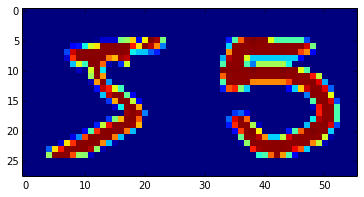

In [13]:
plt.imshow(X_train_topo_both[0], interpolation='nearest')

In [15]:
# Compile and train the network.
# Accuracy is much better than the single layer network, despite the small number of filters.
X_sym = T.matrix()
y_sym = T.ivector()

output = lasagne.layers.get_output(l_out, X_sym)
pred = output.argmax(-1)

loss = T.mean(lasagne.objectives.categorical_crossentropy(output, y_sym))

acc = T.mean(T.eq(pred, y_sym))

params = lasagne.layers.get_all_params(l_out)

# add bias loss
for bias in params[1::2]:
    loss += T.sum(T.sqr(bias * (bias >0)))
    loss -= T.sum(T.sqr(bias * (bias <0) * (bias > -0.05)))

grad = T.grad(loss, params)
updates = lasagne.updates.adam(grad, params, learning_rate=0.005)

f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates)
f_val = theano.function([X_sym, y_sym], [loss, acc])
f_predict = theano.function([X_sym], pred)

BATCH_SIZE = 64
N_BATCHES = len(X_train) // BATCH_SIZE
N_VAL_BATCHES = len(X_val) // BATCH_SIZE

train_batches = batch_gen(X_train_flat_both, y_train_both, BATCH_SIZE)
val_batches = batch_gen(X_val_flat_both, y_val_both, BATCH_SIZE)

#### Addition from me :see values before train (robintibor@gmail.com) ####
train_loss = 0
train_acc = 0
for _ in range(N_BATCHES):
    X, y = next(train_batches)
    loss, acc = f_val(X, y)
    train_loss += loss
    train_acc += acc
train_loss /= N_BATCHES
train_acc /= N_BATCHES

val_loss = 0
val_acc = 0
for _ in range(N_VAL_BATCHES):
    X, y = next(val_batches)
    loss, acc = f_val(X, y)
    val_loss += loss
    val_acc += acc
val_loss /= N_VAL_BATCHES
val_acc /= N_VAL_BATCHES
print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
        -1, train_loss, val_loss, val_loss/train_loss))
print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))
### End Addition from me (robintibor@gmail.com) ####

for epoch in range(10):
    train_loss = 0
    train_acc = 0
    for _ in range(N_BATCHES):
        X, y = next(train_batches)
        loss, acc = f_train(X, y)
        train_loss += loss
        train_acc += acc
    train_loss /= N_BATCHES
    train_acc /= N_BATCHES

    val_loss = 0
    val_acc = 0
    for _ in range(N_VAL_BATCHES):
        X, y = next(val_batches)
        loss, acc = f_val(X, y)
        val_loss += loss
        val_acc += acc
    val_loss /= N_VAL_BATCHES
    val_acc /= N_VAL_BATCHES
    
    print('Epoch {}, Train (val) loss {:.03f} ({:.03f}) ratio {:.03f}'.format(
            epoch, train_loss, val_loss, val_loss/train_loss))
    print('Train (val) accuracy {:.03f} ({:.03f})'.format(train_acc, val_acc))

Epoch -1, Train (val) loss 0.198 (0.174) ratio 0.883
Train (val) accuracy 0.922 (0.936)
Epoch 0, Train (val) loss 0.197 (0.172) ratio 0.874
Train (val) accuracy 0.924 (0.940)
Epoch 1, Train (val) loss 0.194 (0.185) ratio 0.951
Train (val) accuracy 0.926 (0.932)
Epoch 2, Train (val) loss 0.189 (0.171) ratio 0.907
Train (val) accuracy 0.928 (0.934)
Epoch 3, Train (val) loss 0.187 (0.162) ratio 0.867
Train (val) accuracy 0.929 (0.940)
Epoch 4, Train (val) loss 0.185 (0.174) ratio 0.941
Train (val) accuracy 0.929 (0.941)
Epoch 5, Train (val) loss 0.186 (0.172) ratio 0.926
Train (val) accuracy 0.928 (0.935)
Epoch 6, Train (val) loss 0.183 (0.174) ratio 0.954
Train (val) accuracy 0.931 (0.932)
Epoch 7, Train (val) loss 0.181 (0.199) ratio 1.099
Train (val) accuracy 0.932 (0.923)
Epoch 8, Train (val) loss 0.178 (0.167) ratio 0.942
Train (val) accuracy 0.932 (0.938)
Epoch 9, Train (val) loss 0.181 (0.167) ratio 0.923
Train (val) accuracy 0.931 (0.937)


In [16]:
lasagne.layers.get_all_param_values(lasagne.layers.get_all_layers(l_out))[1::2]

[array([-0.0823731 , -0.05776102, -0.16291626], dtype=float32),
 array([-1.40684211, -0.05992256, -0.0513148 ], dtype=float32),
 array([-0.18731338, -0.14550507, -0.68854141], dtype=float32),
 array([-0.06931689, -0.77925187], dtype=float32)]

In [17]:
import pickle
pickle.dump(l_out, open('data/mnist/two-digit/three-conv-pool-negative-bias.pkl', 'w'))

In [17]:
# We can look at the output after the convolutional layer 
filtered = lasagne.layers.get_output(l_conv, X_sym)
f_filter = theano.function([X_sym], filtered)

In [18]:
# Filter the first few training examples
im = f_filter(X_train[:10])
print(im.shape)

(10, 3, 26, 26)


In [19]:
# Rearrange dimension so we can plot the result as RGB images
im = np.rollaxis(np.rollaxis(im, 3, 1), 3, 1)

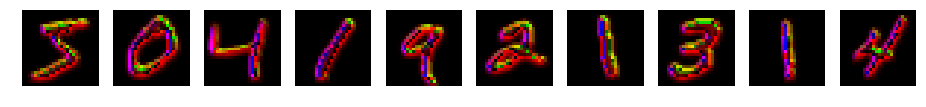

In [20]:
# We can see that each filter seems different features in the images
# ie horizontal / diagonal / vertical segments
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(im[i], interpolation='nearest')
    plt.axis('off')